In [1]:
!pip install tqdm

In [0]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from tqdm import tqdm_notebook as tqdm
import json
import seaborn as sns

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from metafeatures import Metafeatures

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
GOOGLE_DRIVE_PATH_PREFIX = '/content/drive/My Drive/AutoML/'

In [0]:
accuracies_df_path = GOOGLE_DRIVE_PATH_PREFIX + 'data/Metrics/Classification/accuracies.csv'
balanced_accuracies_df_path = GOOGLE_DRIVE_PATH_PREFIX + 'data/Metrics/Classification/balanced_accuracies.csv'

accuracies_df = pd.read_csv(accuracies_df_path, index_col=[0])
balanced_accuracies_df = pd.read_csv(balanced_accuracies_df_path, index_col=[0])

multiclass_accuracies_df_path = GOOGLE_DRIVE_PATH_PREFIX + 'data/Metrics/Classification/Multiclass/accuracies.csv'
multiclass_balanced_accuracies_df_path = GOOGLE_DRIVE_PATH_PREFIX + 'data/Metrics/Classification/Multiclass/balanced_accuracies.csv'

multiclass_accuracies_df = pd.read_csv(multiclass_accuracies_df_path, index_col=[0])
multiclass_balanced_accuracies_df = pd.read_csv(multiclass_balanced_accuracies_df_path, index_col=[0])

In [0]:
all_accuracies_df = accuracies_df.append(multiclass_accuracies_df)
all_balanced_accuracies_df = balanced_accuracies_df.append(multiclass_balanced_accuracies_df)

### Calculate all KPIs

In [0]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [0]:
def get_kpis_for_dataset(dataset_id):
  mfs_dump_path = '/content/drive/My Drive/AutoML/kpis/Classification__'
  mfs_path = '{}/{}.json'.format(mfs_dump_path, dataset_id)
  try:
    with open(mfs_path, 'r') as f:
      mfs = json.load(f)
    return mfs
  except FileNotFoundError:
    # calculate kpis for this dataset
    data, target = fetch_openml(data_id=dataset_id, return_X_y=True, as_frame=True)
    mf = Metafeatures(data, target, task='classification')
    mfs = mf.compute()
    with open(mfs_path, 'w') as f:
      json.dump(mfs, f, indent=4, cls=NumpyEncoder)
    return mfs


### Generate dataset

In [0]:
kpis_df = pd.DataFrame()

In [0]:
rows_loop = tqdm(all_accuracies_df.iterrows(), total=all_accuracies_df.shape[0])
for test_ind, row in rows_loop:
  # get KPIs of dataset
  # rename columns (add test__ prefix)
  test_mfs = get_kpis_for_dataset(test_ind)
  test_mfs = {'test__'+k: v for k, v in test_mfs.items()}

  columns_loop = tqdm(row.items(), total=row.shape[0])
  for ref_ind, acc in columns_loop:    
    # loop over columns, calculate metafeatures of each column, add ref__ prefix, 
    # turn acc to 1/0, append test__ mfs to ref__ mfs, set target to 1/0
    try:
      balanced_acc = all_balanced_accuracies_df.loc[test_ind, ref_ind]
      if not np.isnan(acc) and not np.isnan(balanced_acc):
        ref_mfs = get_kpis_for_dataset(ref_ind)
        ref_mfs = {'ref__'+k: v for k, v in ref_mfs.items()}
        all_mfs = {**test_mfs, **ref_mfs}
        # pipeline_status = acc >= 0.8
        all_mfs['PIPELINE_ACC'] = acc
        all_mfs['PIPELINE_BALANCED_ACC'] = balanced_acc
        kpis_df = kpis_df.append(pd.Series(all_mfs, name='{}_{}'.format(test_ind, ref_ind)))
    except Exception as e:
      print('{}: {}: {}'.format(test_ind, ref_ind, e))
      continue

In [16]:
kpis_df

,PIPELINE_ACC,PIPELINE_BALANCED_ACC,ref__class_entropy,ref__dataset_dimensionality,ref__dataset_ratio,ref__decision_tree_1_accuracy,ref__decision_tree_1_balanced_accuracy,ref__decision_tree_3_accuracy,ref__decision_tree_3_balanced_accuracy,ref__gaussian_nb_accuracy,ref__gaussian_nb_balanced_accuracy,ref__knn_5_accuracy,ref__knn_5_balanced_accuracy,ref__lda_accuracy,ref__lda_balanced_accuracy,ref__log_dataset_dimensionality,ref__log_nb_instances,ref__majority_target_class_ratio,ref__max_entropy_categorical_features,ref__max_information_gain_categorical_features,ref__max_max_numeric_feautures,ref__max_mean_numeric_feautures,ref__max_median_numeric_feautures,ref__max_min_numeric_feautures,ref__max_mutual_informaiton_categorical_features,ref__max_stdev_numeric_feautures,ref__max_var_numeric_feautures,ref__mean_entropy_categorical_features,ref__mean_information_gain_categorical_features,ref__mean_max_numeric_feautures,ref__mean_mean_numeric_feautures,ref__mean_median_numeric_feautures,ref__mean_min_numeric_feautures,ref__mean_mutual_informaiton_categorical_features,ref__mean_stdev_numeric_feautures,ref__mean_target_class_ratio,ref__mean_var_numeric_feautures,ref__median_entropy_categorical_features,ref__median_information_gain_categorical_features,ref__median_max_numeric_feautures,...,test__pca_2,test__q1_max_numeric_feautures,test__q1_mean_numeric_feautures,test__q1_median_numeric_feautures,test__q1_min_numeric_feautures,test__q1_stdev_numeric_feautures,test__q1_var_numeric_feautures,test__q3_max_numeric_feautures,test__q3_mean_numeric_feautures,test__q3_median_numeric_feautures,test__q3_min_numeric_feautures,test__q3_stdev_numeric_feautures,test__q3_var_numeric_feautures,test__random_tree_2_accuracy,test__random_tree_2_balanced_accuracy,test__ratio_categorical_numeric_features,test__ratio_features_with_missing_vals,test__ratio_instances_with_missing_vals,test__ratio_numeric_categorical_features,test__stdev_entropy_categorical_feautures,test__stdev_information_gain_categorical_features,test__stdev_max_numeric_feautures,test__stdev_mean_numeric_feautures,test__stdev_median_numeric_feautures,test__stdev_min_numeric_feautures,test__stdev_mutual_informaiton_categorical_features,test__stdev_stdev_numeric_feautures,test__stdev_target_class_ratio,test__stdev_var_numeric_feautures,ref__max_entropy_categorical_feautures,ref__mean_entropy_categorical_feautures,ref__median_entropy_categorical_feautures,ref__min_entropy_categorical_feautures,ref__stdev_entropy_categorical_feautures,test__max_entropy_categorical_features,test__mean_entropy_categorical_features,test__median_entropy_categorical_features,test__min_entropy_categorical_features,test__pca_3,test__stdev_entropy_categorical_features
782_1,0.933333,0.932515,0.824730,23.631579,0.042316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.162584,6.800170,0.761693,1.421514,NaN,4880.0,1263.094604,611.0,0.24,0.301642,1871.399048,3.502134e+06,0.321345,NaN,1210.666626,348.504242,203.633347,0.040000,0.056730,405.173248,0.166667,6.134093e+05,0.182222,NaN,392.500000,...,0.147541,50.000000,3.125000,3.125000,-43.75000,19.482534,456.407566,50.000000,19.375000,19.375000,-11.25000,29.604357,953.256298,0.808333,0.818358,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,16.25000,16.250000,32.500000,NaN,10.121822,0.02500,496.848724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
782_1008,0.900000,0.901860,0.683337,54.142857,0.018470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.991626,5.937536,0.569921,1.077556,1.039721,NaN,NaN,NaN,NaN,0.411234,NaN,NaN,0.913288,0.245470,NaN,NaN,NaN,NaN,0.211970,NaN,0.500000,NaN,1.011404,0.116858,NaN,...,0.147541,50.000000,3.125000,3.125000,-43.75000,19.482534,456.407566,50.000000,19.375000,19.375000,-11.25000,29.604357,953.256298,0.808333,0.818358,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,16.25000,16.250000,32.500000,NaN,10.121822,0.02500,496.848724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
782_1026,0.883333,0.884003,0.623917,19.375000,0.051613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.963984,5.043425,0.683871,2

In [0]:
kpis_df = kpis_df.query('PIPELINE_ACC < 1.0')
kpis_df = kpis_df.query('PIPELINE_BALANCED_ACC < 1.0')

In [0]:
kpis_df.to_csv(GOOGLE_DRIVE_PATH_PREFIX + 'kpis_classification_.csv')

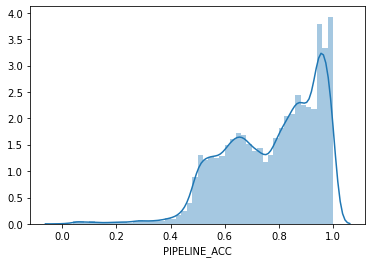

In [22]:
sns.distplot(kpis_df['PIPELINE_ACC'])

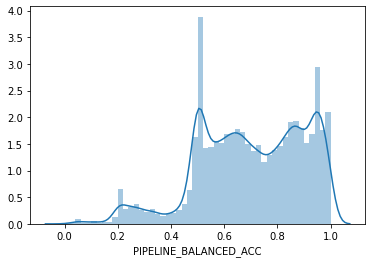

In [23]:
sns.distplot(kpis_df['PIPELINE_BALANCED_ACC'])

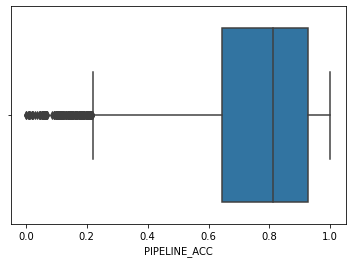

In [26]:
sns.boxplot(kpis_df['PIPELINE_ACC'])

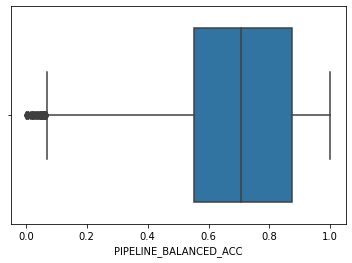

In [27]:
sns.boxplot(kpis_df['PIPELINE_BALANCED_ACC'])